# CNN for counting 
This fil is for CNN applicationThis notebook presents a CNN-based approach developed for COBALT to automate sperm cell counting in microscopic images. The goal is to build a reliable model that can accurately detect and count cells, streamlining the fertility analysis process.

We’ll cover data preparation, model design, and evaluation to achieve an efficient and accurate cell-counting solution.

---

# Importing necessary libraries for the project

In [38]:


# Standard libraries
import sys
import os

# Adding a custom toolkit repository to the system path
# This allows for easy importing of custom tools from 'tool_kit' located in a parent directory
path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)

# Import custom toolkit functions (e.g., utility functions or model-related functions)
import tool_kit as tk

# Data manipulation and numerical operations
import numpy as np  # To install: `pip install numpy`
import pandas as pd  # To install: `pip install pandas`

# PyTorch library for image transformations
import torchvision.transforms as transforms  # To install: `pip install torchvision`

# Library for data visualization
import matplotlib.pyplot as plt  # To install: `pip install matplotlib`

# Importing PyTorch summary for model inspection
from torchsummary import summary  # To install: `pip install torchsummary`

# Core PyTorch libraries for deep learning
import torch  # To install: `pip install torch`
import torch.nn as nn
import torch.nn.functional as F

# Additional utility functions and tools
from torch.utils.data.sampler import SubsetRandomSampler
from costumize_data import CustomDataset  # Custom dataset handler


# Loading and Displaying Dataset Information

In [39]:
# Setting the path to the dataset using a function from the custom toolkit
# This allows the toolkit to locate and access the dataset files.
tk.set_path_to_dataset('..')
# Loading the images and mask data using functions from the toolkit
images = tk.load_data_image()
mask = tk.load_data_mask()
# Displaying the first few entries of each DataFrame to understand the data structure
print(' images =\n', images.head())
print(' mask =\n', mask.head())
# 'mask' DataFrame:# - Type: pandas DataFrame# - Contains: Each entry has the image ID and the count of cells present in the image.
# 'images' DataFrame:# - Type: pandas DataFrame # - Contains: Each entry has the image ID, cell count, mask availability (boolean), and blur status.


 images =
                             image_id  nb_cells mask  blur
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
 mask =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1


Select the data frame that you want to use # Selecting DataFrame Based on User Choice: Mask or Image

In [41]:
mask_or_image = 'mask'  # Variable to determine which dataset to use

if mask_or_image == 'mask':
    df = mask  # If 'mask' is selected, assign the mask DataFrame to df
    # Filter the rows in the DataFrame where 'image_id' contains 'w1' (case insensitive)
    df = df[df['image_id'].str.contains("w1", case=False, na=False)]
else:
    df = images.copy()  # If 'image' is selected, create a copy of the images DataFrame
    # Remove the 'blur' and 'mask' columns from the DataFrame
    df.drop(columns=['blur', 'mask'], inplace=True) 
    # Uncomment the following line to filter images by 'w1' if needed
    # df = df[df['image_id'].str.contains("w1", case=False, na=False)]

df  # Display the resulting DataFrame


,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
6,SIMCEPImages_A01_C1_F1_s04_w1.TIF,1
8,SIMCEPImages_A01_C1_F1_s05_w1.TIF,1
...,...,...
1190,SIMCEPImages_A24_C100_F1_s21_w1.TIF,100
1192,SIMCEPImages_A24_C100_F1_s22_w1.TIF,100
1194,SIMCEPImages_A24_C100_F1_s23_w1.TIF,100
1196,SIMCEPImages_A24_C100_F1_s24_w1.TIF,100


## Separation test set et train set

In [ ]:
# CNN for Counting Sperm Cells in Microscopic Images

In [42]:
# Set the fraction of data to be used for testing
frac = 0.2  # 20% of the data will be used for the test set
# Sample a subset of the DataFrame for testing without replacement
df_test = df.sample(frac=frac, replace=False, random_state=42)
# Create the training set by dropping the test set entries from the original DataFrame. Then shuffle the remaining data to create the training set
df_train = df.drop(df_test.index).sample(frac=1, random_state=42)

print('len(df) =', len(df))  # Total number of samples in the original DataFrame
print('len(df_train) =', len(df_train))  # Number of samples in the training set
print('len(df_test) =', len(df_test))  # Number of samples in the test set

print('df_train =\n', df_train.head())  # Show the first few rows of the training DataFrame
print('df_test =\n', df_test.head())  # Show the first few rows of the testing DataFrame


len(df) = 600
len(df_train) = 480
len(df_test) = 120
df_train =
                                 image_id  nb_cells
192   SIMCEPImages_A04_C14_F1_s22_w1.TIF        14
1022  SIMCEPImages_A21_C87_F1_s12_w1.TIF        87
976   SIMCEPImages_A20_C83_F1_s14_w1.TIF        83
692   SIMCEPImages_A14_C57_F1_s22_w1.TIF        57
990   SIMCEPImages_A20_C83_F1_s21_w1.TIF        83
df_test =
                                 image_id  nb_cells
220   SIMCEPImages_A05_C18_F1_s11_w1.TIF        18
838   SIMCEPImages_A17_C70_F1_s20_w1.TIF        70
1130  SIMCEPImages_A23_C96_F1_s16_w1.TIF        96
154   SIMCEPImages_A04_C14_F1_s03_w1.TIF        14
362   SIMCEPImages_A08_C31_F1_s07_w1.TIF        31


## Test d'affichage d'images et de nombre de cellules dedans  


In [7]:
"""IMG_HEIGHT = 128*2
IMG_WIDTH = 128*2
df_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_train=df.to_numpy()
df_test=df.to_numpy()"""

'IMG_HEIGHT = 128*2\nIMG_WIDTH = 128*2\ndf_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_train=df.to_numpy()\ndf_test=df.to_numpy()'

In [8]:
df.shape

(600, 2)

In [9]:
print( len(df_train))

480


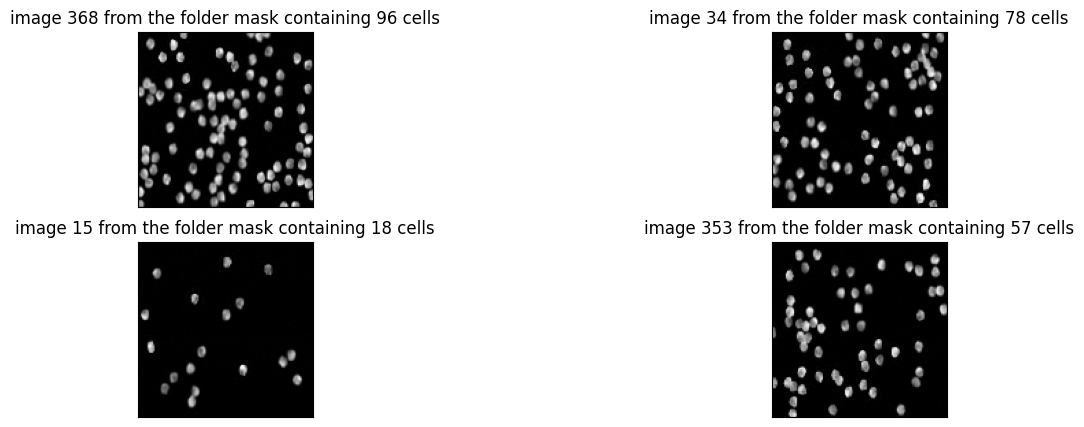

In [10]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
Matrix=df_train
n_img_to_show = 4
fig = plt.figure(figsize=(15,5))
indices=list(range(len(Matrix)))
np.random.shuffle(indices)

for i in range(n_img_to_show):
    ax=fig.add_subplot(2, n_img_to_show//2 , i+1 , xticks=[], yticks=[])
    ax.imshow(np.squeeze(tk.get_image(img_id=Matrix['image_id'].iloc[indices[i]],img_height=IMG_HEIGHT, img_width=IMG_WIDTH, mask_or_image= mask_or_image)),cmap='gray')
    
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {Matrix['nb_cells'].iloc[indices[i]]} cells')
plt.show()

## convertit les données pour pytorch

In [11]:

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  indices= list( range(len(train_data)))
  np.random.shuffle(indices)
  split= int( np.floor(valid_size * len(train_data)))
  train_indexes, valid_indexes = indices[split:], indices[:split]
  valid_samplers= SubsetRandomSampler(valid_indexes)
  train_samplers= SubsetRandomSampler(train_indexes)
  valid_loader =torch.utils.data.DataLoader( train_data, batch_size = batch_size, sampler = valid_samplers)
  train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler= train_samplers)
  return train_loader, valid_loader, test_loader


In [12]:
type(df_train)

pandas.core.frame.DataFrame

In [13]:

transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)) # Resize to desired dimensions
])
train_data= CustomDataset(df_train,transform=transform)
train_data.set_path_to_dataset('..')
test_data= CustomDataset(df_test,transform=transform)
test_data.set_path_to_dataset('..')
train_loader, valid_loader, test_loader =create_data_loaders(batch_size, valid_size, train_data, test_data)

In [14]:
print( train_data.__getitem__(200)[0].shape)

torch.Size([1, 128, 128])


## Image et mask correspondant généré avec u-net

In [15]:

dropout = 0.1
nb_filtre = 8

p = 1  # for padding 
k = 3  # for kernel size
s = 1  # for stride
pool_k = 2
pool_s = 2
n_conv= [1 , 1, 1 , 1]
do_pool= [1 , 1 , 1 ,1]  

class CNN(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNN, self).__init__()

        self.im_height = img_height
        self.im_width = img_width
        
        self.size= 0
        self.conv1 = self.conv_block(in_channels=1, out_channels=nb_filtre*(2**0))
        self.conv2 = self.conv_block(in_channels=nb_filtre*(2**0), out_channels=nb_filtre *(2**1))
        self.conv3 = self.conv_block(in_channels=nb_filtre *(2**1), out_channels=nb_filtre *(2**2))
        self.conv4 = self.conv_block(in_channels=nb_filtre *(2**2), out_channels=nb_filtre *(2**3))

        self.pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s)

        # Calculate output dimensions after all convolutions and pooling
        self.calculate_output_dims()
        #print( 'self size=', self.size)
        #print(self.size)
        # First dense layer
        self.dense1 = self.dense_layer(size=self.size)

        # Second dense layer
        self.size //= 4  # Adjust size for the second dense layer
        self.dense2 = self.dense_layer(size=self.size)
        self.size //= 4  # Adjust size for the second dense layer
        self.dense3 = self.dense_layer(size=self.size)
        self.size//= 4
        # Final fully connected layer
        self.fc = nn.Linear(self.size, 1)  # Adjusted for output size

    def calculate_output_dims(self):
        # Recalculate height and width after each convolution and pooling layer
        current_filters = nb_filtre
        for i in range(sum(n_conv)):
            # After convolution
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            current_filters = nb_filtre * (2 ** (i))
        for i in do_pool:
            if i == 1:
         #       print( 'im a in i')
                # After pooling
                self.im_height//= pool_k
                self.im_width //= pool_k
            
                

        # Flattened size for dense layers
        # Note: Using the final number of filters (nb_filtre * (2**n_con))
        self.size = self.im_height * self.im_width * current_filters 
        #note = consider pooling
        


    def dense_layer(self , size ):
        
        block = nn.Sequential(
            nn.Linear(size, size // 2),
            #nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(size // 2, size // 4),
            #nn.ReLU(inplace=True)
        )
        return block

    def conv_block(self, in_channels, out_channels):
        """
        Convolutional Block: Conv2d -> ReLU -> Dropout -> Conv2d -> ReLU -> Dropout
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),  # Dropout after each conv layer
            
        )
        return block
    def forward(self, x):
        """
        The forward path is : conv_block --> conv_block --> conv_block --> conv_block --> layer
        """
        if n_conv[0] == 1: 
            x = self.conv1(x)
        if do_pool[0]==1: 
            x=self.pool(x)
        if n_conv[1] == 1: 
            x = self.conv2(x)
        if do_pool[1]==1: 
            x=self.pool(x)
        if n_conv[2] == 1 : 
            x = self.conv3(x)
        if do_pool[2]==1: 
            x=self.pool(x)
        if n_conv[3] == 1: 
            x = self.conv4(x)
        if do_pool[3]==1: 
            x=self.pool(x)
        
        #print( 'size=', self.size )
        
        #print('At the end of the convolution layer x shape =', x.shape)
        # Flatten before dense layers
        x = x.view(x.size(0), -1)  # Keep batch size intac
        #print ('x=', x.shape)
        #print( x.shape)
        x = self.dense1(x)
        
        # Uncomment if you have a second dense layer
        x = self.dense2(x)
        x=self.dense3(x)
        #print(f"Dense2 shape: {x.shape}")  # Debug: check shape
        #out put layer 
        x = self.fc(x)
        
        return x


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [17]:
CNN_1 = CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH )
CNN_1.to(device=device)  

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
  (dense3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=

In [18]:
#CNN(train_data.__getitem__(0)[0])
train_data.__getitem__(0)[0].shape

torch.Size([1, 128, 128])

In [19]:
single_batch = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH)
output = CNN_1(single_batch)
print( output)

tensor([[-0.1047]], grad_fn=<AddmmBackward0>)


In [20]:

summary(CNN_1, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
         MaxPool2d-2            [-1, 8, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           1,168
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                 [-1, 2048]       8,390,656
          Dropout-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

In [21]:
criterion =nn.MSELoss()
#criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(CNN_1.parameters(), lr=0.001)

In [22]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'mymodel.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [23]:
train_losses, valid_losses=training(n_epochs, train_loader, valid_loader, CNN_1, criterion, optimizer)

c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.ms

epoch: 1 	training Loss: 4561.945031 	validation Loss: 3448.763275
validation loss decreased (inf --> 3448.763275).  Saving model ...
epoch: 2 	training Loss: 2290.797225 	validation Loss: 869.107674
validation loss decreased (3448.763275 --> 869.107674).  Saving model ...
epoch: 3 	training Loss: 932.692060 	validation Loss: 983.903984
epoch: 4 	training Loss: 923.919288 	validation Loss: 831.476242
validation loss decreased (869.107674 --> 831.476242).  Saving model ...
epoch: 5 	training Loss: 936.813864 	validation Loss: 799.027843
validation loss decreased (831.476242 --> 799.027843).  Saving model ...
epoch: 6 	training Loss: 937.803098 	validation Loss: 921.598234
epoch: 7 	training Loss: 917.751137 	validation Loss: 938.740138
epoch: 8 	training Loss: 909.933189 	validation Loss: 814.508326
epoch: 9 	training Loss: 913.795567 	validation Loss: 794.896052
validation loss decreased (799.027843 --> 794.896052).  Saving model ...
epoch: 10 	training Loss: 930.982330 	validation Los

Text(0, 0.5, 'loss value')

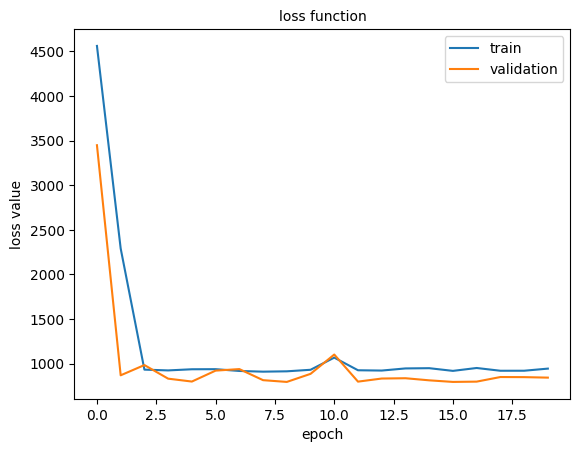

In [24]:
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), valid_losses)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

In [25]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(101))
  class_total = list(0. for i in range(101))
  #creat a empty dict of 101 elements
  dict={}
  for i in range(1,101):
      dict[i]=[]
  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)

      test_loss += loss.item()*data.size(0)
      
      pred = torch.floor(output) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          number_expected = label.data[i]
          class_correct[number_expected] += correct[i].item()
          class_total[number_expected] += 1
          number_expected = int(number_expected)
          dict[number_expected].append(int(pred[i]))
      
  
  #print and return the results
  for i in range(100):
     if class_total[i] > 0 : 
        print( 'For the true value ', i, 'the predicted values are ', dict[i])
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(100):
      if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test accuracy of %1s: %2.2f%% (%2d/%2d)' % (str(i), accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
      #else: 
        #print('Test accuracy of %1s: N/A (0/0)' % str(i))

  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [26]:
evaluation( CNN_1, test_loader, criterion)

For the true value  1 the predicted values are  [54, 54, 54, 54, 53]
For the true value  5 the predicted values are  [55, 55, 55]
For the true value  10 the predicted values are  [55, 55, 55, 56, 55, 56]
For the true value  14 the predicted values are  [56, 56, 56, 56, 57, 56, 56, 57, 56]
For the true value  18 the predicted values are  [57, 57, 57, 57, 57]
For the true value  23 the predicted values are  [57, 58, 58, 57, 57]
For the true value  27 the predicted values are  [57, 58, 58]
For the true value  31 the predicted values are  [58, 58, 58, 58, 58, 58, 58]
For the true value  35 the predicted values are  [58, 58, 58, 58, 58]
For the true value  40 the predicted values are  [59, 59, 59, 59, 59, 58]
For the true value  44 the predicted values are  [59, 59, 59]
For the true value  48 the predicted values are  [59, 59, 59, 59, 59]
For the true value  53 the predicted values are  [60, 59, 59, 60]
For the true value  57 the predicted values are  [59, 60, 60, 60]
For the true value  61

**implement the method in kaggle**

In [27]:


class KAGGLE_CNN(nn.Module):
    def __init__(self, img_height, img_width, img_channels=1, padding=1, kernel_size=3, pool_size=2,
                 first_filters=32, second_filters=64, third_filters=128, 
                 dropout_conv=0.3, dropout_dense=0.3):
        super(KAGGLE_CNN, self).__init__()

        # Layer 1: Initial Conv layer with padding
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout1 = nn.Dropout(dropout_conv)

        # Layer 2: Second convolutional block
        self.conv4 = nn.Conv2d(in_channels=first_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv6 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout2 = nn.Dropout(dropout_conv)

        # Layer 3: Third convolutional block
        self.conv7 = nn.Conv2d(in_channels=second_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv8 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv9 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout3 = nn.Dropout(dropout_conv)

        # Layer 4: Fourth convolutional block
        self.conv10 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv11 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv12 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.pool4 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout4 = nn.Dropout(dropout_conv)

        # Calculate flattened size for fully connected layers
        self.flattened_size = self._calculate_flattened_size(img_height, img_width, pool_size)

        # Dense layers
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.leaky_relu1 = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.leaky_relu2 = nn.LeakyReLU()
        self.batch_norm2 = nn.BatchNorm1d(512)

        # Output layer
        self.output = nn.Linear(512, 1)

    def _calculate_flattened_size(self, height, width, pool_size):
        # Apply pool size four times based on the four pooling layers in the model
        for _ in range(4):
            height //= pool_size
            width //= pool_size
        return height * width * 128  # `128` is `third_filters`, which is the final filter count

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu1(self.fc1(x))
        x = self.batch_norm1(x)

        x = self.leaky_relu2(self.fc2(x))
        x = self.batch_norm2(x)

        x = self.output(x)
        x=F.relu(x)
        return x


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [29]:
CNN_2 = KAGGLE_CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH )
CNN_2.to(device=device)  

KAGGLE_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_siz

In [30]:
#CNN(train_data.__getitem__(0)[0])
train_data.__getitem__(0)[0].shape

torch.Size([1, 128, 128])

In [31]:
single_batch = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH)
#output = CNN_2(single_batch)
#print( output)

In [32]:

summary(CNN_2, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
            Conv2d-2         [-1, 32, 128, 128]           9,248
            Conv2d-3         [-1, 32, 128, 128]           9,248
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
            Conv2d-7           [-1, 64, 64, 64]          36,928
            Conv2d-8           [-1, 64, 64, 64]          36,928
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
           Conv2d-12          [-1, 128, 32, 32]         147,584
           Conv2d-13          [-1, 128, 32, 32]         147,584
        MaxPool2d-14          [-1, 128,

In [33]:
criterion =nn.MSELoss()
#criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD(CNN_2.parameters(), lr=0.001)

In [34]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'kaggle_model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [35]:
train_losses_k, valid_losses_k=training(n_epochs, train_loader, valid_loader, CNN_2, criterion, optimizer)

epoch: 1 	training Loss: 2399.755950 	validation Loss: 3549.249990
validation loss decreased (inf --> 3549.249990).  Saving model ...
epoch: 2 	training Loss: 1835.365813 	validation Loss: 863.503878
validation loss decreased (3549.249990 --> 863.503878).  Saving model ...
epoch: 3 	training Loss: 1811.990786 	validation Loss: 3549.249949
epoch: 4 	training Loss: 1760.755337 	validation Loss: 797.952001
validation loss decreased (863.503878 --> 797.952001).  Saving model ...
epoch: 5 	training Loss: 1673.275922 	validation Loss: 3549.249980
epoch: 6 	training Loss: 1701.917784 	validation Loss: 3267.604421
epoch: 7 	training Loss: 1548.108354 	validation Loss: 1485.277924
epoch: 8 	training Loss: 1307.863503 	validation Loss: 879.802622
epoch: 9 	training Loss: 932.312485 	validation Loss: 803.405891
epoch: 10 	training Loss: 895.194744 	validation Loss: 799.606099
epoch: 11 	training Loss: 893.910503 	validation Loss: 804.653702
epoch: 12 	training Loss: 894.583616 	validation Loss: 7

Text(0, 0.5, 'loss value')

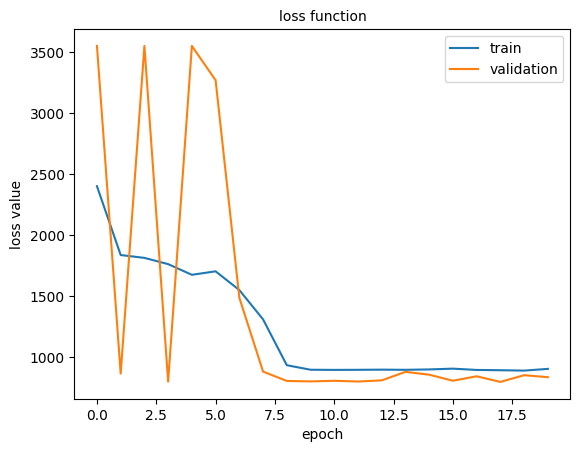

In [36]:
plt.plot(range(n_epochs), train_losses_k)
plt.plot(range(n_epochs), valid_losses_k)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

In [37]:
evaluation( CNN_2, test_loader, criterion)

For the true value  1 the predicted values are  [57, 57, 57, 57, 57]
For the true value  5 the predicted values are  [57, 57, 57]
For the true value  10 the predicted values are  [57, 57, 57, 58, 57, 57]
For the true value  14 the predicted values are  [58, 57, 58, 58, 58, 58, 58, 58, 58]
For the true value  18 the predicted values are  [58, 58, 58, 58, 58]
For the true value  23 the predicted values are  [58, 58, 58, 58, 58]
For the true value  27 the predicted values are  [58, 58, 58]
For the true value  31 the predicted values are  [58, 58, 58, 58, 58, 58, 58]
For the true value  35 the predicted values are  [59, 58, 58, 58, 58]
For the true value  40 the predicted values are  [59, 59, 59, 59, 59, 58]
For the true value  44 the predicted values are  [59, 59, 59]
For the true value  48 the predicted values are  [59, 59, 59, 59, 59]
For the true value  53 the predicted values are  [59, 59, 59, 59]
For the true value  57 the predicted values are  [59, 59, 59, 59]
For the true value  61